# Variational Autoencoder - Basic Example

Here, in this notebook, we'll see how to create a basic Variational Autoencoder to generate new data for the dataset, we have used Sine function as datasource. 

**NOTE: HERE WE WILL NOT USE THE SINE FUNCTIONS'S DATASET FOR AUTOENCODER TIMESERIES. WE'LL USE IT IN A DIFFERENT LSTM AUTOENCODER.**

The VAEs can be used to generate new data for unbalanced dataset. Just train a VAE with the class with less examples and use the VAE to generate more examples for the class.

Here, in this notebook, we'll use the sine series dataset with 1000 examples to train a VAE and generate new dataset for sine series itself.

In [1]:
import torch.nn as nn
import torch
from torch.nn.modules.container import Sequential
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'
pass

## Loading or Formulating the dataset

In order to create the random dataset let's use the **sine** function. The structure of the dataset would be :

| X   |
| :---: | :--:|
| $[sin(a), sin(a+1), sin(a+2)..., sin(a+n)]$ |
| $[sin(b), sin(b+1), sin(b+2)..., sin(b+n)]$ |
| $... ... ... ... ...$  | ... |
| $[sin(z), sin(z+1), sin(z+2)..., sin(z+n)]$ |

$a ... z$ are the random number between $0 - 100.$<br/>
$n$ is the maximum data points we need. Here we choose it to be 200.<br/>
The rows in the dataset let's say would be $1000$.



In [3]:
main_series = []

for _ in range(0,1000):

    rn = np.random.randint(0,100)

    series_1 = []

    for i in range(rn,rn+200):
        series_1.append(np.sin(i) + 1)

    main_series.append((series_1))

df = pd.DataFrame(main_series)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1.963795,1.745113,0.841377,0.083478,0.168225,1.017702,1.850904,1.901788,1.123573,0.231745,...,1.329962,0.383936,0.004316,0.540123,1.498739,1.998817,1.580587,0.628568,0.018042,0.310324
1,1.566108,1.999520,1.513978,0.555887,0.006111,0.370112,1.313229,1.968364,1.733190,0.823924,...,1.860054,1.035368,0.178165,0.076553,0.823954,1.733211,1.968357,1.313200,0.370089,0.006115
2,0.000793,0.493634,1.452026,1.994827,1.622989,0.678378,0.029465,0.272857,1.184782,1.926819,...,0.973479,1.826846,1.920014,1.167326,0.260799,0.033890,0.695218,1.636761,1.992869,1.436138
3,0.595962,1.551427,1.999912,1.529083,0.571817,0.008221,0.356462,1.296369,1.963795,1.745113,...,1.885939,1.868951,1.053053,0.188379,0.069905,0.806556,1.721059,1.972623,1.329962,0.383936
4,1.313229,1.968364,1.733190,0.823924,0.076542,0.178182,1.035398,1.860069,1.893997,1.105988,...,1.968357,1.313200,0.370089,0.006115,0.555914,1.514004,1.999521,1.566083,0.612191,0.014849


As we see, all the points for sine values are there in individual dataframe's column, so let's grab all the columns and create the array out of it. Leter let's convert that array into a `FloatTensor`.

In [5]:
X_train, X_test = df.iloc[:800,:].values, df.iloc[:-200,:].values

In [6]:
X_train_tensor = torch.FloatTensor(X_train).to(device)

X_test_tensor = torch.FloatTensor(X_test).to(device)

Once we have the `FloatTensor`, the next step is to create the `DataLoader` using `TensorDataset`. 

So, let's convert the `FloatTensor` to `TensorDataset` and then `TensorDataset` to `DataLoader`.

In [7]:
train_ds = TensorDataset(X_train_tensor, X_train_tensor)
test_ds = TensorDataset(X_test_tensor, X_test_tensor)

train_loader = DataLoader(train_ds, 64, shuffle=True)
test_loader = DataLoader(test_ds, 64, shuffle=True)

## Modelling

![VAE](helper/vae.png)

### **Encoder**

The first part of the an **Variational AutoEncoder** model is the **Encoder**. The Encoder would take a $200$ features in this case (as our sine dataset has $200$ features created) and layer by layer, it will reduce the size of the features to $25$ points in the end, the size is in the variable `latent_vector_size`.

In [8]:
latent_vector_size = 25

In [9]:

class EncoderNN(nn.Module):

    def __init__(self):

        super(EncoderNN, self).__init__()

        self.linear_1 = nn.Linear(200, 100)
        self.linear_2 = nn.Linear(100, 50) 
        self.linear_3 = nn.Linear(50, latent_vector_size) 

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))

        mu = self.linear_3(x)

        sigma = torch.exp(self.linear_3(x))

        z = mu + sigma*self.N.sample(mu.shape)

        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        return z



### **Decoder**

The second part of the an **Variational AutoEncoder** model is the **Decoder**. The Decoder would take it from where Encoder finishes. The Decoder would take the $25$ features here in this case and layer by layer it will increase the size of the features from $25$ to $200$ points in the end.

So the Decoder again reconstructs the data to the same number of data points form where the Encoder started. We will then use this reconstructed data, compare it with the original data and calculate the $MSE$. The whole idea is to try reduce this error.

In [10]:
class DecoderNN(nn.Module):

    def __init__(self):
        super(DecoderNN, self).__init__()

        self.linear_1 = nn.Linear(latent_vector_size, 50) 
        self.linear_2 = nn.Linear(50, 100)
        self.linear_3 = nn.Linear(100, 200)

    def forward(self, x):
        x = F.relu(self.linear_1(x))
        x = F.relu(self.linear_2(x))
        reconstruction = torch.sigmoid(self.linear_3(x))
        return reconstruction

In [11]:
class AutoencoderNN(nn.Module):

  def __init__(self):
    super(AutoencoderNN,self).__init__()
    
    self.encoderNN = EncoderNN().to(device)
    self.decoderNN = DecoderNN().to(device)


  def forward(self,x):
    x = self.encoderNN(x)  
    x = self.decoderNN(x)
    return x

In [12]:
model = AutoencoderNN().to(device)
print(model)

AutoencoderNN(
  (encoderNN): EncoderNN(
    (linear_1): Linear(in_features=200, out_features=100, bias=True)
    (linear_2): Linear(in_features=100, out_features=50, bias=True)
    (linear_3): Linear(in_features=50, out_features=25, bias=True)
  )
  (decoderNN): DecoderNN(
    (linear_1): Linear(in_features=25, out_features=50, bias=True)
    (linear_2): Linear(in_features=50, out_features=100, bias=True)
    (linear_3): Linear(in_features=100, out_features=200, bias=True)
  )
)


In [13]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

In [14]:
epochs = 1000

running_loss_history = []
epoch_list = []
val_running_loss_history = []

for epoch in range(epochs):

    running_loss = 0.0
    val_loss = 0.0

    # See we're not using any labels here.
    model.train()
    for inputs, _ in train_loader:

        inputs = inputs.to(device)

        optimizer.zero_grad()

        output = model(inputs)

        loss = ((inputs - output)**2).sum() + model.encoderNN.kl

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    else:
        model.eval()
        with torch.no_grad():

            for val_inputs, _ in test_loader:

                val_inputs = val_inputs.to(device)

                val_encoded = model.encoderNN(val_inputs)

                val_outputs = model(val_inputs)

                loss = ((val_inputs - val_outputs)**2).sum() + model.encoderNN.kl

                val_loss += loss.item()

                
    if (epoch+1) % 10 == 0:

        running_loss_history.append(running_loss / len(train_loader.dataset))
        
        print('epoch :', (epoch+1))
        print('training loss: {:.4f}'.format(running_loss / len(train_loader.dataset)))
        print('validation loss: {:.4f}'.format(val_loss / len(test_loader.dataset)))
        epoch_list.append(epoch + 1)

        print('_'*20)

epoch : 10
training loss: 113.5313
validation loss: 112.9486
____________________
epoch : 20
training loss: 110.7110
validation loss: 110.6228
____________________
epoch : 30
training loss: 110.0982
validation loss: 110.0852
____________________
epoch : 40
training loss: 108.2779
validation loss: 107.8972
____________________
epoch : 50
training loss: 104.1684
validation loss: 104.4082
____________________
epoch : 60
training loss: 103.7679
validation loss: 103.4795
____________________
epoch : 70
training loss: 103.9303
validation loss: 103.4492
____________________
epoch : 80
training loss: 103.3033
validation loss: 103.1998
____________________
epoch : 90
training loss: 103.2865
validation loss: 103.3626
____________________
epoch : 100
training loss: 103.5274
validation loss: 103.0366
____________________
epoch : 110
training loss: 103.5933
validation loss: 103.4290
____________________
epoch : 120
training loss: 102.9756
validation loss: 103.1694
____________________
epoch : 130
t

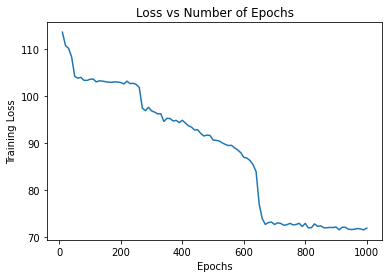

In [15]:
plt.plot(epoch_list,running_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Loss vs Number of Epochs")
plt.show()

### Generating New Data

In [16]:
def generate_data():
    latent = torch.randn(1, latent_vector_size, device=device).view(-1)
    k = model.decoderNN(latent.view(-1)).detach().cpu()
    plt.figure(figsize=(15,4))
    plt.plot(k)
    plt.ylabel('some numbers')
    plt.show()

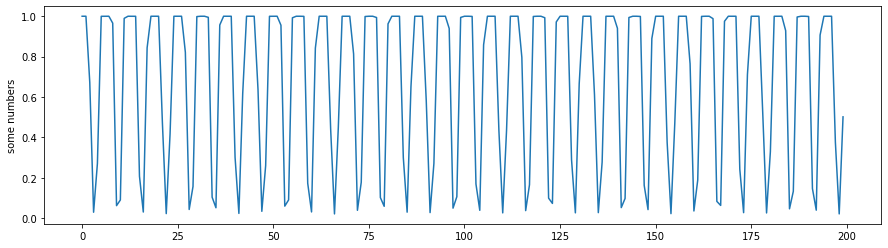

In [17]:
generate_data()